## Face and Facial Keypoint detection

After you've trained a neural network to detect facial keypoints, you can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` you created and applied in Notebook 2, whose job was tp rescale, normalize, and turn any iimage into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy
numpy.set_printoptions(threshold=numpy.nan)

%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

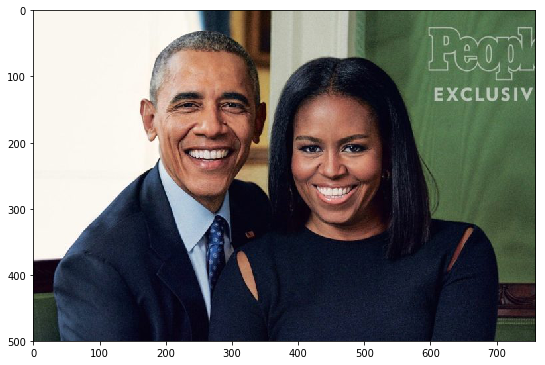

In [152]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)


# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, you'll use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). You can even [add eye detections](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) as an *optional* exercise in using Haar detectors.

An example of face detection on a variety of images is shown below.

<img src='images/haar_cascade_ex.png' width=80% height=80%/>


In [153]:
image.shape

(500, 759, 3)

In [154]:
#image[0]

[[179  74 174 174]
 [371 144 160 160]]
179 74 174 174
371 144 160 160


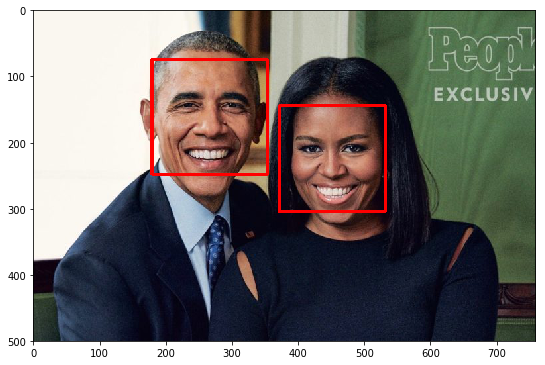

In [155]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
print(faces)
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    print(x,y,w,h)
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once you have an image to work with (and, again, you can select any image of faces in the `images/` directory), the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [156]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_3_30epoch.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=4096, bias=True)
  (fc1_drop): Dropout2d(p=0.4)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=136, bias=True)
)

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### TODO: Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### TODO: Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face:

<img src='images/michelle_detected.png' width=30% height=30%/>




In [157]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


In [158]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
       # predicted_key_pts = predicted_key_pts*50.0+100
        predicted_key_pts = predicted_key_pts*50.0-5
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            #ground_truth_pts = ground_truth_pts*50.0+100
            #
            ground_truth_pts = ground_truth_pts*50.0-5
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
                
        plt.axis('off')

    plt.show()
    
# call it
# visualize_output(test_images, test_outputs, gt_pts)

In [159]:
predicted_key_pts

array([[ 57.190987,  94.18852 ],
       [ 58.822735, 107.60159 ],
       [ 61.379967, 120.12017 ],
       [ 64.158394, 132.56918 ],
       [ 68.3801  , 145.11998 ],
       [ 75.918274, 156.01501 ],
       [ 84.71757 , 163.32686 ],
       [ 97.3486  , 170.01625 ],
       [115.12792 , 172.33334 ],
       [131.30121 , 168.1047  ],
       [141.25523 , 161.24165 ],
       [148.44891 , 153.97983 ],
       [155.44089 , 142.31259 ],
       [159.77618 , 129.48831 ],
       [161.4783  , 116.870285],
       [163.78864 , 104.86806 ],
       [164.48833 ,  91.77211 ],
       [ 70.22066 ,  81.16311 ],
       [ 75.823746,  76.49881 ],
       [ 84.0053  ,  75.21003 ],
       [ 91.37459 ,  75.303635],
       [ 97.750206,  77.35651 ],
       [124.74056 ,  77.01006 ],
       [130.81895 ,  75.957886],
       [137.97697 ,  75.48944 ],
       [145.79662 ,  75.650085],
       [152.27386 ,  79.194084],
       [112.237015,  91.79836 ],
       [112.755264, 100.76802 ],
       [113.477295, 110.05396 ],
       [11

In [160]:
# Tried different rotations, didn't worked
## Rotate keypoints 
#horizontal_img = cv2.flip( img, 0 )
#vertical_img = cv2.flip( img, 1 )
#both_img = cv2.flip( predicted_key_pts, 1)
#np.flipud(predicted_key_pts)
#rot90 = np.rot90(predicted_key,2)#

In [161]:
show_all_keypoints(np.squeeze(img_rescaled),np.fliplr(predicted_key_pts))

NameError: name 'img_rescaled' is not defined

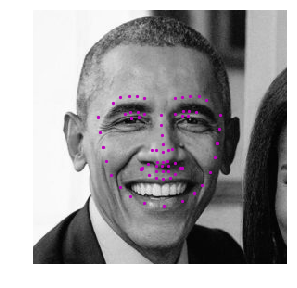

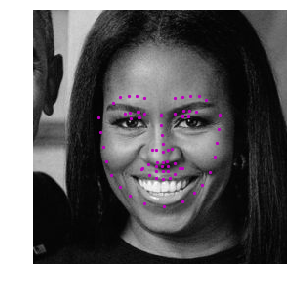

In [138]:
image_copy = np.copy(image)
 
# loop over the detected faces from your haar cascade
for i, (x,y,w,h) in enumerate(faces):
   
    p = 50
    # Select the region of interest that is the face in the image
    roi = image_copy[y-p:y+h+p, x-p:x+w+p]
   
    ## TODO: Convert the face region from RGB to grayscale
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
 
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    img = gray / 255.0
   
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    img = cv2.resize(img, (224, 224))
   
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    img = img.reshape(1, 1, img.shape[0], img.shape[1])
    img = torch.from_numpy(img)
    img = img.type(torch.FloatTensor)
   
    ## TODO: Make facial keypoint predictions using your loaded, trained network
    key_pts = net(img)
    key_pts = key_pts.view(68,2).data.numpy() * 50.0 + 100.0
   
 
    ## TODO: Display each detected face and the corresponding keypoints    
    plt.figure(figsize=(10,5))
    ax = plt.subplot(1, 2, i+1)
 
    #Scale keypoints to roi dimensions
    key_pts[:, 0] *= roi.shape[0] / 224
    key_pts[:, 1] *= roi.shape[1] / 224
    plt.imshow(gray, cmap='gray')
    #plt.imshow(cv2.resize(gray, (224,224)), cmap='gray')
    plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker='.', c='m')
    plt.axis('off')